## Anomaly Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import tifffile
from sklearn.cluster import KMeans

In [21]:
def get_simplastic_v1():
    path = 'data/Mytilene/simplastic_v1'
    path_patchM1 = path +'/M1'+'/patch'
    path_labelM1 = path +'/M1'+'/label'

    path_patchM2 = path +'/M2'+'/patch'
    path_labelM2 = path +'/M2'+'/label'

    sizeM1 = len(os.listdir(path +'/M1'+'/patch'))
    sizeM2 = len(os.listdir(path +'/M2'+'/patch'))

    patch_list = []
    label_list = []


    for i in range(sizeM1):
        patch = tifffile.imread(path_patchM1 + '/patch_{}_{}.tif'.format('M1',i))
        label = tifffile.imread(path_labelM1 + '/label_{}_{}.tif'.format('M1',i))
        patch_list.append(patch)
        label_list.append(label)

    for i in range(sizeM2):
        patch = tifffile.imread(path_patchM2 + '/patch_{}_{}.tif'.format('M2',i))
        label = tifffile.imread(path_labelM2 + '/label_{}_{}.tif'.format('M2',i))
        patch_list.append(patch)
        label_list.append(label)

    return patch_list, label_list

In [22]:
patch_list, label_list = get_simplastic_v1()

In [23]:
print(len(patch_list))
print(patch_list[0].shape)

print(len(label_list))
print(label_list[0].shape)

68
(60, 70, 12)
68
(60, 70)


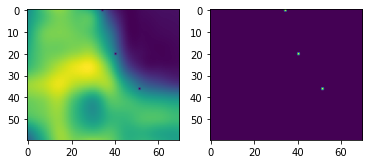

In [24]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(patch_list[0][:,:,0])
plt.subplot(1,2,2)
plt.imshow(label_list[0][:,:])
plt.show()

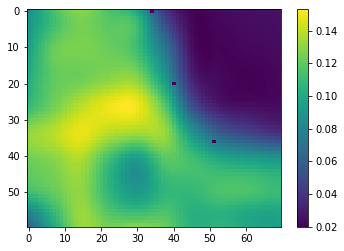

In [25]:
plt.imshow(patch_list[0][:,:,0])
plt.colorbar()

In [26]:
X = patch_list[0][:,:,0]
np.histogram(X.flatten(), bins=10)

(array([ 751,  135,  111,  104,  126,  338,  802, 1007,  554,  272],
       dtype=int64),
 array([0.02   , 0.03331, 0.04662, 0.05993, 0.07324, 0.08655, 0.09986,
        0.11317, 0.12648, 0.13979, 0.1531 ]))

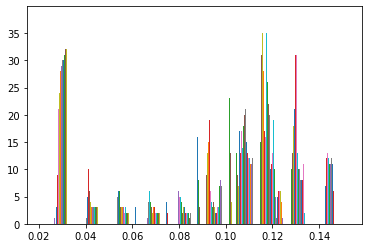

In [27]:
plt.hist(X, bins=10)
plt.show()

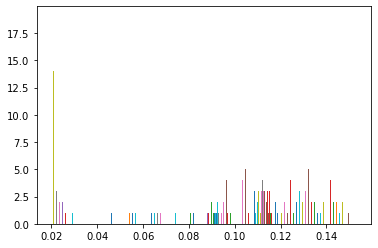

In [28]:
plt.hist(X, bins=100)
plt.show()

In [2]:
# import the images
def get_tiles_as_array(folder):
    band_list = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
    path = 'data/'+ folder
    folder_list = os.listdir(path)
    m,n = 600,1400
    array = np.zeros((m,n,len(band_list)))

    i = 0
    for band in folder_list:
        for wanted_band in band_list:
            if wanted_band in band:
                img = tifffile.imread(os.path.join(path,band))
                array[:,:,i] = img[:m,:n]
                i+=1
    return array

In [3]:
arrayM1 = get_tiles_as_array('Mytilene/M1')
arrayM2 = get_tiles_as_array('Mytilene/M2')

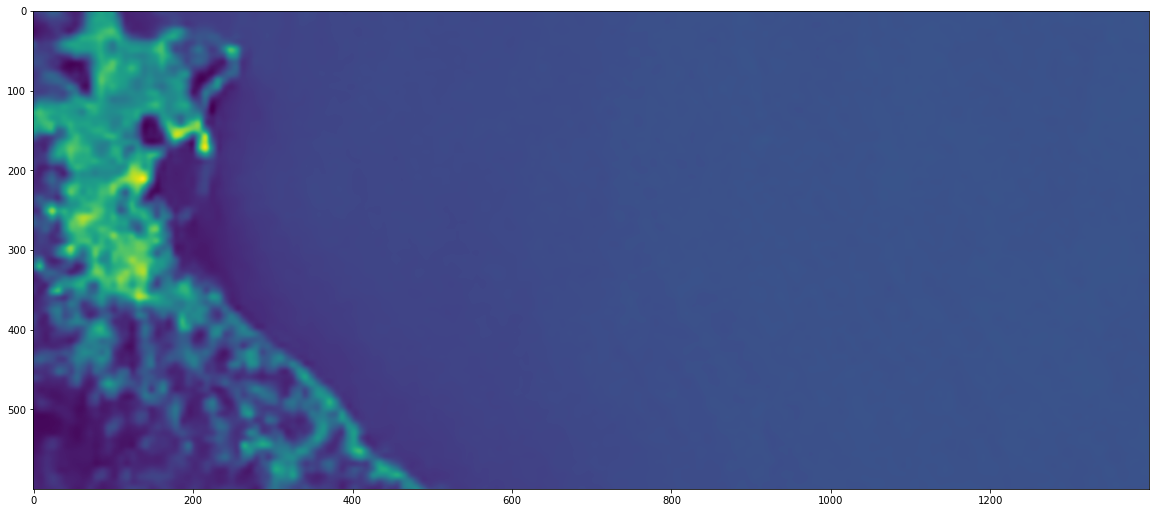

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(arrayM1[:,:,0])

In [49]:
print(arrayM1.shape)

(600, 1400, 12)


In [50]:
def kmeans(array, nb_clust):
    m,n = array.shape[0],array.shape[1]
    if len(array.shape)==2:
        X = array.flatten().reshape(-1, 1)
    elif len(array.shape)>2:
        array_flat = np.array([array[:,:,i].flatten() for i in range(array.shape[2])])
        X=(np.transpose(array_flat))
    kmeans = KMeans(n_clusters=nb_clust,  init='k-means++', n_init=10, max_iter=300).fit(X)
    labels=kmeans.labels_
    img_labels = labels.reshape(m,n)
    return img_labels

In [53]:
img_labelsM1 = kmeans(arrayM1,2)

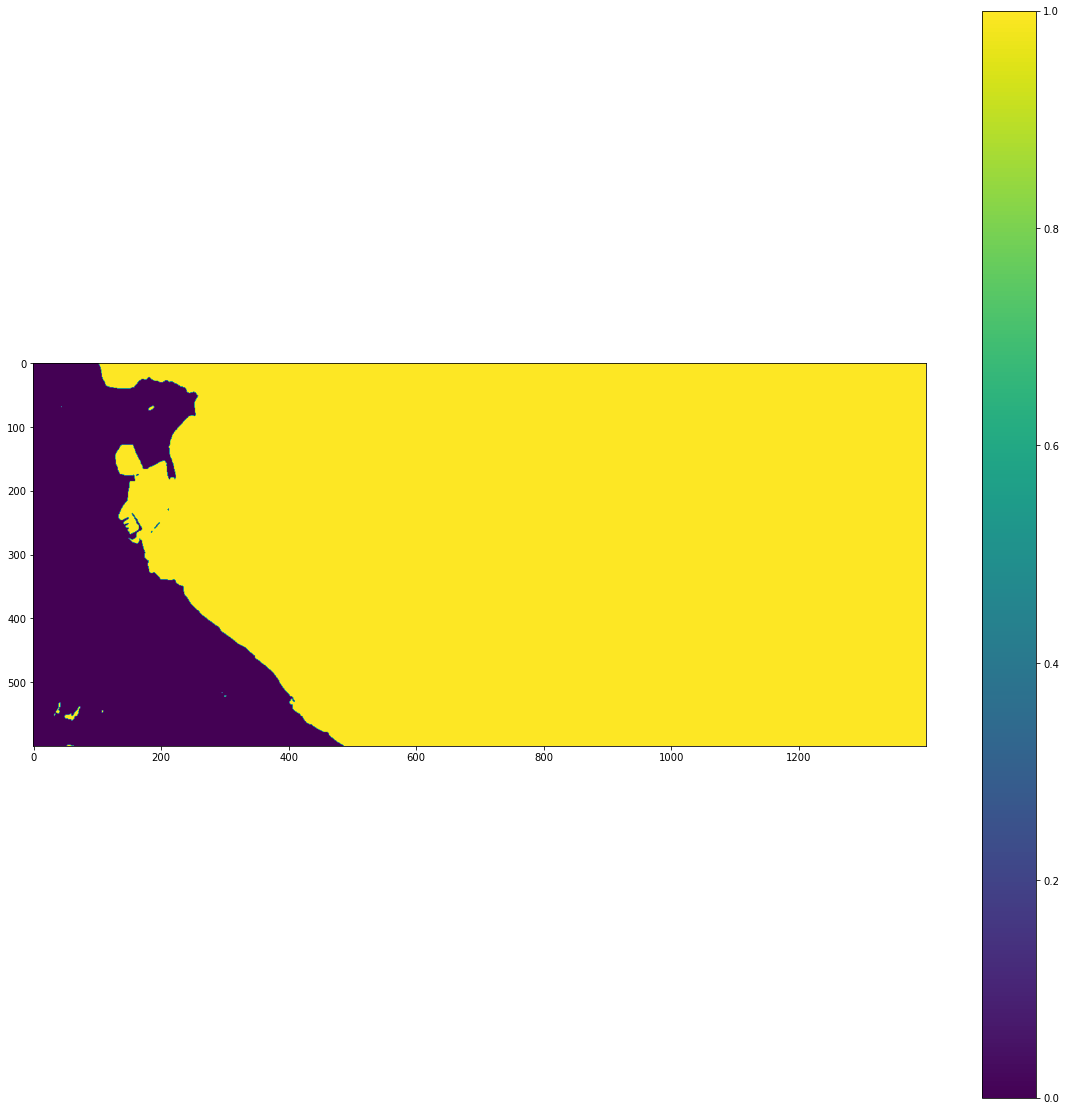

In [54]:
plt.figure(figsize=(20,20))
plt.imshow(img_labelsM1)
plt.colorbar()
plt.show()

In [56]:
def elbow_for_fun(X_test, Kmin, Kmax):
    labels, inertia, nb_iter = [], [], []
    for k in range(Kmin,Kmax):
        m,n = X_test.shape[0],X_test.shape[1]
        if len(X_test.shape)==2:
            X = X_test.flatten().reshape(-1, 1)
        elif len(X_test.shape)>2:
            X_flat = np.array([X_test[:,:,i].flatten() for i in range(X_test.shape[2])])
            X=(np.transpose(X_flat))
        kmeans = KMeans(n_clusters=k,  init='k-means++', n_init=10, max_iter=300).fit(X)
        labels.append(kmeans.labels_.reshape(m,n))
        inertia.append(kmeans.inertia_)
        nb_iter.append(kmeans.n_iter_)
    plt.figure()
    plt.plot(range(Kmin,Kmax),inertia, label='Inertia')
    plt.plot(range(Kmin,Kmax),nb_iter, label = 'Iterations')
    plt.xlabel("nb of clusters")
    plt.legend()
    plt.show()
    return labels, inertia, nb_iter

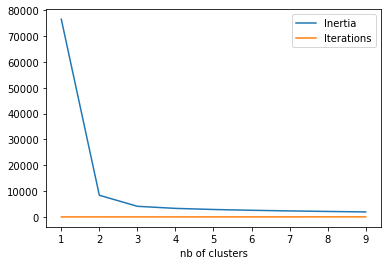

In [58]:
labels, inertia, nb_iter = elbow_for_fun(arrayM1, 1, 10)

<function matplotlib.pyplot.show(close=None, block=None)>

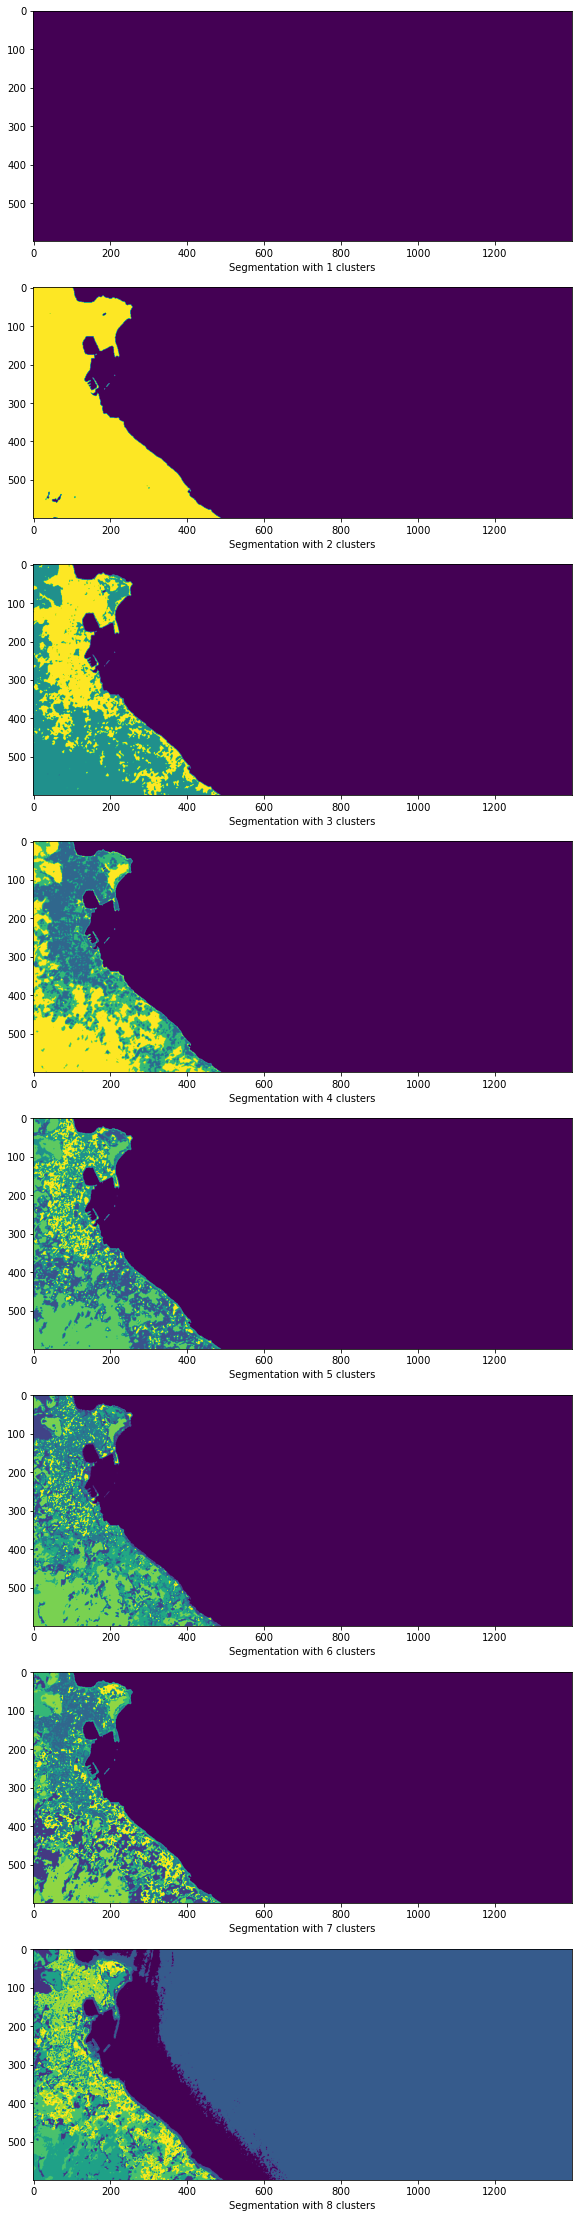

In [59]:
plt.figure(figsize=(10,5*len(labels)))
for i in range(1,len(labels)):
    plt.subplot(len(labels),1,i)
    plt.imshow(labels[i-1])
    plt.xlabel(f"Segmentation with {i} clusters")
plt.show

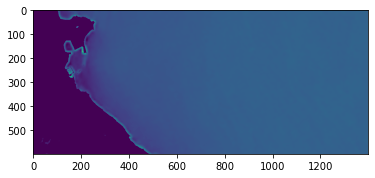

In [60]:
# removing the ground

# change 1 or 0 to relouve the groundn depends on the segmentation results
M1_ocean = arrayM1
M1_ocean[img_labelsM1==0]= np.nan
M1_ocean[img_labelsM1==0]= 0
X_ocean = M1_ocean[:,:,0]
plt.imshow(X_ocean)

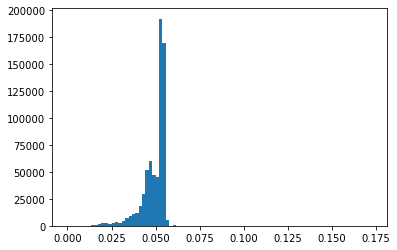

In [61]:
plt.hist(X_ocean.flatten()[X_ocean.flatten()>0], bins=90)
plt.show()

In [62]:
# anomaly detection ... one feature/example (1 sepectral band) ...kinda

# Supposed to choose an non anomalous example, to extract mu and sigma ...
X_train = X_ocean[0:200, 400:1200].flatten()
print(X_train.shape)
mu, sigma = np.nanmean(X_train, axis=0), np.nanstd(X_train, axis= 0) 
print(f'Mean = {mu}, Standard Deviation = {sigma}')

(160000,)
Mean = 0.051404467569454576, Standard Deviation = 0.0028570154007584252


In [63]:
def predict_anomaly(X, mu, sigma, eps):
    p_x = (1 / (np.sqrt(2*np.pi)*sigma)) * np.exp(-np.power((X-mu),2) / (2*sigma**2))
    return ( p_x < eps)

In [64]:
print(X_ocean.shape)

anomaly = predict_anomaly(X_ocean, mu, sigma, 0.1)
anomaly[anomaly==True]=1
anomaly[anomaly==False]=0
print(anomaly.shape)

(600, 1400)
(600, 1400)


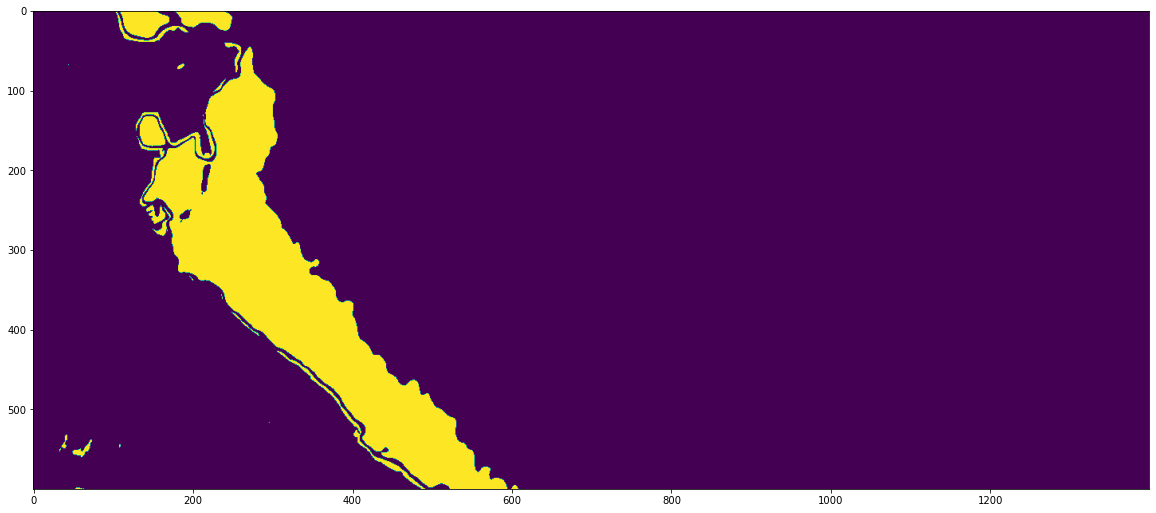

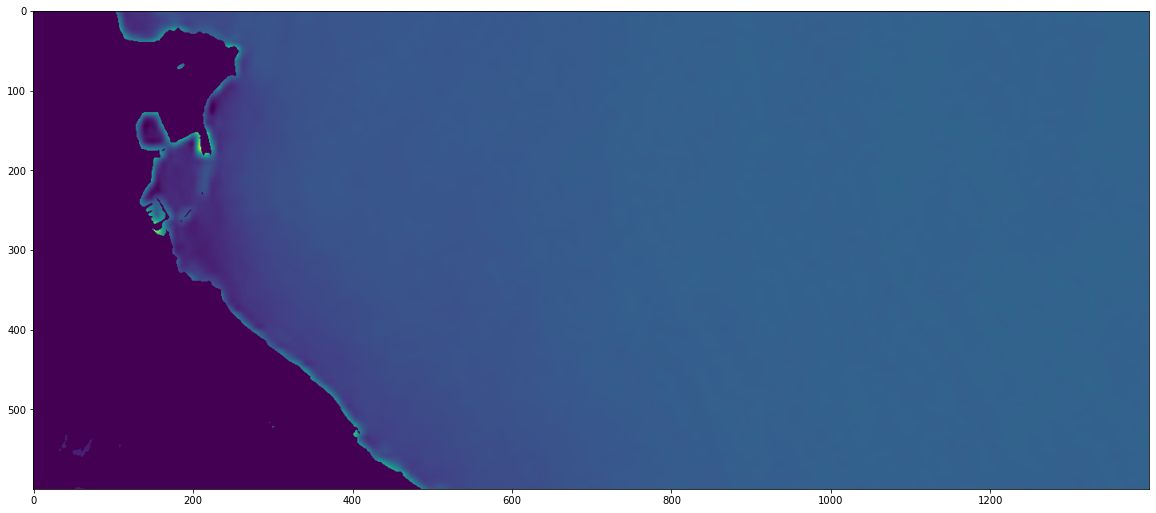

In [65]:
plt.figure(figsize=(20,20))
anomaly[X_ocean==0]= 0
plt.imshow(anomaly)
#plt.colorbar()
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(X_ocean)
plt.show()

In [66]:
# anomaly detection ... multiple features/examples (n sepectral band) ...kinda

# Supposed to choose an non anomalous example, to extract mu and sigma ...
train_data = M1_ocean[0:200, 400:1200,:]
X_train = np.array([train_data[:,:,i].flatten() for i in range(train_data.shape[2])]).T
print(X_train.shape)
mu, sigma = np.nanmean(X_train, axis=0), np.nanstd(X_train, axis= 0)
for i in range(mu.shape[0]):
    print(f'Feature {i}: Mean = {mu[i]}, Standard Deviation = {sigma[i]}')

(160000, 12)
Feature 0: Mean = 0.051404467569454576, Standard Deviation = 0.0028570154007584252
Feature 1: Mean = 0.05074902194123715, Standard Deviation = 0.0031636985599132377
Feature 2: Mean = 0.037090355131740214, Standard Deviation = 0.0028294715383917687
Feature 3: Mean = 0.03303370883534663, Standard Deviation = 0.0029274860674395266
Feature 4: Mean = 0.034539695113059134, Standard Deviation = 0.002580741731524452
Feature 5: Mean = 0.032997780089150185, Standard Deviation = 0.0023241871401264115
Feature 6: Mean = 0.033911287611175796, Standard Deviation = 0.0022472982820587826
Feature 7: Mean = 0.03395251510139788, Standard Deviation = 0.002760338216191581
Feature 8: Mean = 0.024467923794314266, Standard Deviation = 0.0018781067994664991
Feature 9: Mean = 0.033862361346534454, Standard Deviation = 0.002345885198189525
Feature 10: Mean = 0.030947381293715444, Standard Deviation = 0.0021509735859784724
Feature 11: Mean = 0.03299043008694425, Standard Deviation = 0.0022965007818921

In [67]:
def predict_anomaly_multifeatures(X, mu, sigma, eps):
    # this method suggest the independance of each feature
    p_x = (np.divide(1,np.sqrt(2*np.pi)*sigma)) * np.exp( np.divide(-np.power((X-mu),2),2*sigma**2))
    return ( np.prod(p_x) < eps)

In [68]:
print(M1_ocean.shape)
anomaly = predict_anomaly(M1_ocean, mu, sigma, 0.5)
print(anomaly.shape)

(600, 1400, 12)
(600, 1400, 12)


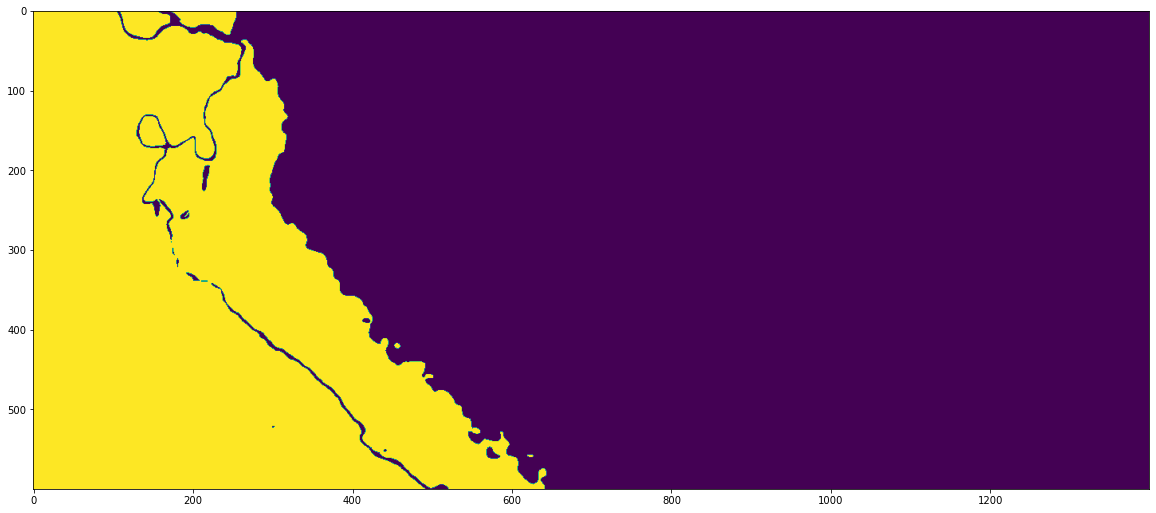

In [69]:
plt.figure(figsize=(20,20))
plt.imshow(anomaly[:,:,0])
plt.show()


In [72]:
# need to compute the multivariate gaussian problem next 
# must have m(examples) >> n(features) otherwise sigma is non invertible

# Supposed to choose an non anomalous example, to extract mu and sigma ...
train_data = M1_ocean[0:200, 400:600,:]
X_train = np.array([train_data[:,:,i].flatten() for i in range(train_data.shape[2])]).T
print(X_train.shape)
mu = np.nanmean(X_train, axis=0)

# technically works but kills the kernel .... X_train.shape = 160000*12...
# sigma_mat = np.nanmean(np.dot(X_train-mu,(X_train-mu).T), axis=0)
sigma_mat = np.cov(X_train)
print(f'Mean = {mu}, Standard Deviation = {sigma_mat}')

(40000, 12)
Mean = [0.04735264 0.04763328 0.03459574 0.03013125 0.03160073 0.03044476
 0.03142572 0.03124631 0.02231954 0.0309142  0.02835876 0.03039883], Standard Deviation = [[5.77224262e-05 5.97096991e-05 6.11133388e-05 ... 5.33533320e-05
  5.30527274e-05 5.54712091e-05]
 [5.97096991e-05 6.24560629e-05 6.36206122e-05 ... 5.51392418e-05
  5.48100004e-05 5.66243916e-05]
 [6.11133388e-05 6.36206122e-05 6.51706162e-05 ... 5.65956086e-05
  5.62454587e-05 5.86425773e-05]
 ...
 [5.33533320e-05 5.51392418e-05 5.65956086e-05 ... 4.98590111e-05
  4.96654522e-05 5.19846156e-05]
 [5.30527274e-05 5.48100004e-05 5.62454587e-05 ... 4.96654522e-05
  4.96345448e-05 5.20418158e-05]
 [5.54712091e-05 5.66243916e-05 5.86425773e-05 ... 5.19846156e-05
  5.20418158e-05 5.58699182e-05]]


In [73]:
def predict_anomaly_multivariate(X, mu, sigma, eps):
    # this method suggest the independance of each feature
    n = len(mu)
    X_mu = X-mu
    p_x = ((2*np.pi)**(-n/2))*(np.linalg.det(sigma)**(-0.5))*np.exp(-0.5*np.dot(np.dot(X_mu.T,np.pinv(sigma)),X_mu))
    return ( p_x < eps)

In [74]:
print(M1_ocean.shape)
anomaly = predict_anomaly(M1_ocean, mu, sigma, 0.5)
print(anomaly.shape)


(600, 1400, 12)
(600, 1400, 12)


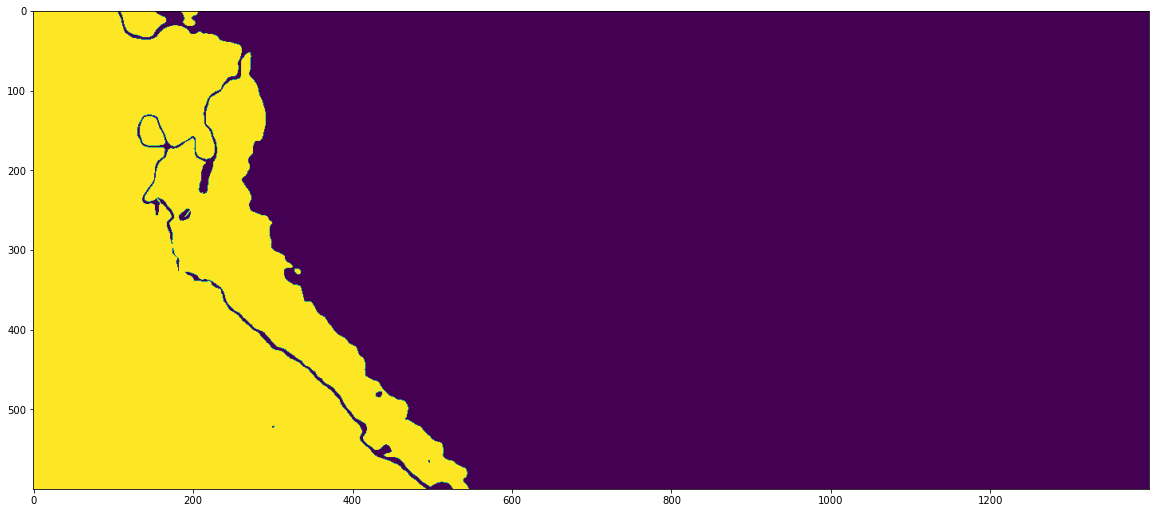

In [75]:
plt.figure(figsize=(20,20))
plt.imshow(anomaly[:,:,0])
plt.show()
